<a href="https://colab.research.google.com/github/franciscogonzalez-gal/statistical-learning-2/blob/main/Proyecto_2_Statistical_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO 2 - Statistical Learning II

**Nombre:** Francisco Gonzalez

**Carnet:** 24002914

## 0) Dependencias e instalación


In [ ]:
!pip install pyclustering

import os, glob, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from collections import deque
import random

from scipy.stats import ks_2samp


from pyclustering.cluster.kmedoids import kmedoids as PyKMedoids

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["axes.grid"] = True


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=03f985310f8c470f0f6ab67ad73a7f6d2f9fb86221d737ec754f05fea4515a20
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


## 1) Carga de datos desde Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Cambia esta ruta si tu carpeta se llama distinto o está en otra ubicación
DATA_DIR = "/content/drive/MyDrive/datos"


FILE_PATH = os.path.join(DATA_DIR, "Online Retail.xlsx")


df = pd.read_excel(
    FILE_PATH
)

# Nos quedamos solo con las columnas relevantes por si el archivo tiene más
expected_cols = ["Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"]
df = df[[c for c in expected_cols if c in df.columns]]
print(df.head(3))
print(df.info())


Mounted at /content/drive
   Quantity         InvoiceDate  UnitPrice  CustomerID         Country
0         6 2010-12-01 08:26:00       2.55     17850.0  United Kingdom
1         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom
2         8 2010-12-01 08:26:00       2.75     17850.0  United Kingdom
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Quantity     541909 non-null  int64         
 1   InvoiceDate  541909 non-null  datetime64[ns]
 2   UnitPrice    541909 non-null  float64       
 3   CustomerID   406829 non-null  float64       
 4   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 20.7+ MB
None


### 1.a) Limpieza básica y exploración inicial


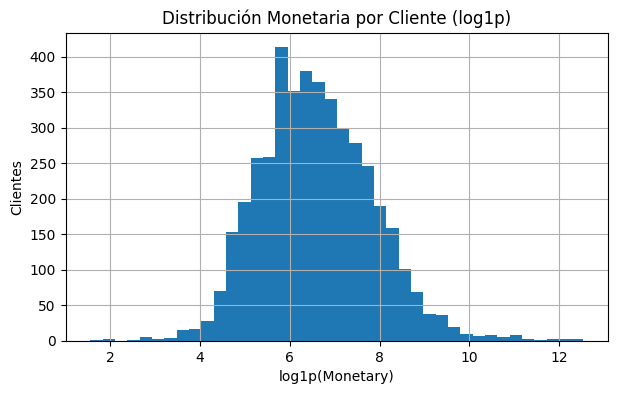

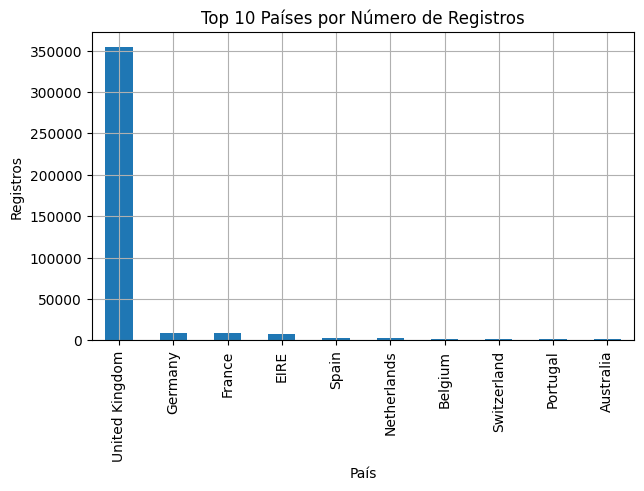

In [ ]:

# Eliminamos CustomerID nulo (para métricas por cliente)
df = df.dropna(subset=["CustomerID"]).copy()
df["CustomerID"] = df["CustomerID"].astype(int)

# Quitamos devoluciones u outliers negativos/0
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()

# Variable auxiliar: valor de línea
df["LineTotal"] = df["Quantity"] * df["UnitPrice"]

# Exploración simple
monetary_by_customer = df.groupby("CustomerID", as_index=False)["LineTotal"].sum().rename(columns={"LineTotal":"Monetary"})
freq_by_customer = df.groupby("CustomerID", as_index=False).size().rename(columns={"size":"Frequency"})

country_counts = df["Country"].value_counts().head(10)

fig, ax = plt.subplots()
ax.hist(np.log1p(monetary_by_customer["Monetary"]), bins=40)
ax.set_title("Distribución Monetaria por Cliente (log1p)")
ax.set_xlabel("log1p(Monetary)")
ax.set_ylabel("Clientes")
plt.show()

fig, ax = plt.subplots()
country_counts.plot(kind="bar", ax=ax)
ax.set_title("Top 10 Países por Número de Registros")
ax.set_xlabel("País")
ax.set_ylabel("Registros")
plt.show()


## 2) Ingeniería de características: RFM


In [ ]:

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Recency: días desde la última compra
recency = df.groupby("CustomerID", as_index=False)["InvoiceDate"].max()
recency["Recency"] = (snapshot_date - recency["InvoiceDate"]).dt.days
recency = recency.drop(columns=["InvoiceDate"])

# Frequency: número de líneas/visitas (aprox.). Si tienes InvoiceNo, usa nunique sobre ese campo.
frequency = freq_by_customer.copy()

# Monetary: gasto total
monetary = monetary_by_customer.copy()

# Unimos RFM
rfm = recency.merge(frequency, on="CustomerID").merge(monetary, on="CustomerID")
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,182,4310.00
2,12348,75,31,1797.24
3,12349,19,73,1757.55
4,12350,310,17,334.40


###  2.a) Preprocesamiento robusto de RFM


In [ ]:

# Copia de trabajo
rfm_proc = rfm.copy()

# Winsorización al p99 para atenuar outliers extremos
for col in ["Recency", "Frequency", "Monetary"]:
    p99 = rfm_proc[col].quantile(0.99)
    rfm_proc[col] = np.clip(rfm_proc[col], None, p99)

# Transformación log1p para colas pesadas
rfm_proc["Recency"]   = np.log1p(rfm_proc["Recency"])
rfm_proc["Frequency"] = np.log1p(rfm_proc["Frequency"])
rfm_proc["Monetary"]  = np.log1p(rfm_proc["Monetary"])

# Escalado estándar
features = ["Recency", "Frequency", "Monetary"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_proc[features])

# Array para la GAN
rfm_array = X_scaled.astype("float32")


In [ ]:
# Normalización para clustering
features = ["Recency", "Frequency", "Monetary"]
X = rfm[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 3) Clustering: K-Means y K-Medoids (pyclustering)


In [ ]:

def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    return sil, db

def run_kmedoids_pyclustering(X_scaled, k, random_state=42):
    """
    Ejecuta K-Medoids con pyclustering usando matriz de distancias.
    Devuelve: labels (np.array de forma [n_samples]), medoids (lista de índices).
    """
    rng = np.random.default_rng(random_state)
    n = X_scaled.shape[0]
    # Matriz de distancias euclidianas
    dist_matrix = pairwise_distances(X_scaled, metric="euclidean")
    # Medoides iniciales aleatorios (índices)
    initial_medoids = rng.choice(n, size=k, replace=False).tolist()

    # pyclustering espera una matriz como lista de listas y 'data_type="distance_matrix"'
    kmed = PyKMedoids(data=dist_matrix.tolist(),
                      initial_index_medoids=initial_medoids,
                      data_type='distance_matrix')
    kmed.process()
    clusters = kmed.get_clusters()
    medoids  = kmed.get_medoids()

    # Convertimos clusters -> vector de etiquetas
    labels = np.full(n, -1, dtype=int)
    for cid, idx_list in enumerate(clusters):
        labels[np.array(idx_list, dtype=int)] = cid
    return labels, medoids

results = []
best_models = {}

for k in range(2, 7):
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km_labels = kmeans.fit_predict(X_scaled)
    sil_km, db_km = evaluate_clustering(X_scaled, km_labels)
    results.append(("KMeans", k, sil_km, db_km))
    best_models.setdefault("KMeans", {})[k] = (kmeans, km_labels, sil_km, db_km)

    # K-Medoids (pyclustering)
    kmed_labels, medoids = run_kmedoids_pyclustering(X_scaled, k, random_state=42)
    sil_kmed, db_kmed = evaluate_clustering(X_scaled, kmed_labels)
    results.append(("KMedoids", k, sil_kmed, db_kmed))
    best_models.setdefault("KMedoids", {})[k] = (("pyclustering", medoids), kmed_labels, sil_kmed, db_kmed)

res_df = pd.DataFrame(results, columns=["Algoritmo","k","Silhouette","DaviesBouldin"]).sort_values(["Algoritmo","k"])
display(res_df)

# Elegimos el mejor por Silhouette (mayor) y validamos con Davies-Bouldin (menor)
best_row = res_df.sort_values(["Silhouette", "DaviesBouldin"], ascending=[False, True]).iloc[0]
best_algo, best_k = best_row["Algoritmo"], int(best_row["k"])
best_model, best_labels, _, _ = best_models[best_algo][best_k]

print(f"Mejor modelo: {best_algo} con k={best_k}")
rfm[f"Cluster_{best_algo}"] = best_labels
rfm.head()


,Algoritmo,k,Silhouette,DaviesBouldin
0,KMeans,2,0.576601,0.626775
2,KMeans,3,0.601978,0.736969
4,KMeans,4,0.358802,0.922312
6,KMeans,5,0.359979,0.839811
8,KMeans,6,0.513361,0.689330
1,KMedoids,2,0.575446,0.632766
3,KMedoids,3,0.304423,0.989561
5,KMedoids,4,0.439561,0.920606
7,KMedoids,5,0.354363,0.902587
9,KMedoids,6,0.379095,1.000711


Mejor modelo: KMeans con k=3


,CustomerID,Recency,Frequency,Monetary,Cluster_KMeans
0,12346,326,1,77183.60,1
1,12347,2,182,4310.00,0
2,12348,75,31,1797.24,0
3,12349,19,73,1757.55,0
4,12350,310,17,334.40,1


## Conclusión del Análisis de Clustering

Se evaluaron dos algoritmos de segmentación de clientes: **KMeans** y **KMedoids**, con un rango de valores de *k* entre 2 y 6. Para cada combinación se calcularon las métricas de calidad:

- **Silhouette Score**: mide la cohesión y separación entre clústeres (valores más cercanos a 1 indican mejor segmentación).  
- **Davies-Bouldin Index**: evalúa la compacidad e independencia de los clústeres (valores más bajos indican mejor desempeño).

### Resultados
- El modelo con **KMeans y k = 3** obtuvo el mejor balance entre ambas métricas:  
  - **Silhouette = 0.602**, superior a los demás escenarios.  
  - **Davies-Bouldin = 0.737**, aceptable en comparación con otros valores de k.  
- KMedoids, aunque consistente, mostró en general un menor desempeño frente a KMeans en este conjunto de datos.

### Interpretación de Segmentos
Con el modelo seleccionado (**KMeans k=3**), se identificaron distintos perfiles de clientes a partir de las variables **Recency, Frequency y Monetary**:
- Segmentos con **alto valor monetario** pero baja frecuencia, representando clientes de compras grandes pero esporádicas.  
- Segmentos con **alta frecuencia** y gasto moderado, que podrían considerarse clientes recurrentes y leales.  
- Segmentos de **bajo valor monetario y frecuencia**, asociados a clientes ocasionales con menor impacto en ingresos.

### Conclusión General
El análisis confirma que **KMeans con k=3 es la mejor opción de clustering** para este caso, proporcionando una segmentación clara y diferenciada que puede ser utilizada como base para estrategias de marketing personalizadas, programas de fidelización o análisis de rentabilidad por tipo de cliente.


## 4) Reducción de dimensionalidad: PCA y t-SNE


Varianzas (autovalores): [1.5257 0.9065 0.5684]
Suma varianzas: 3.0007
Varianza explicada (PCA): [0.5085 0.3021]


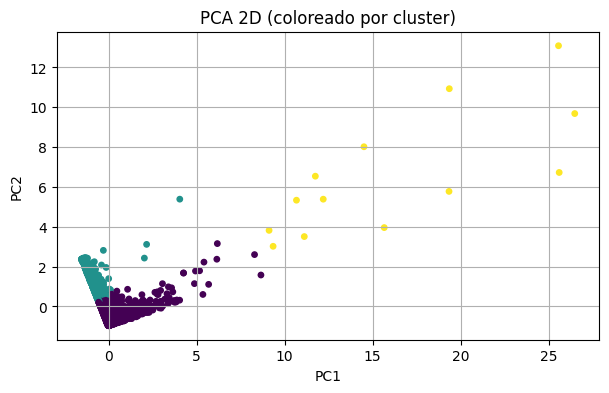

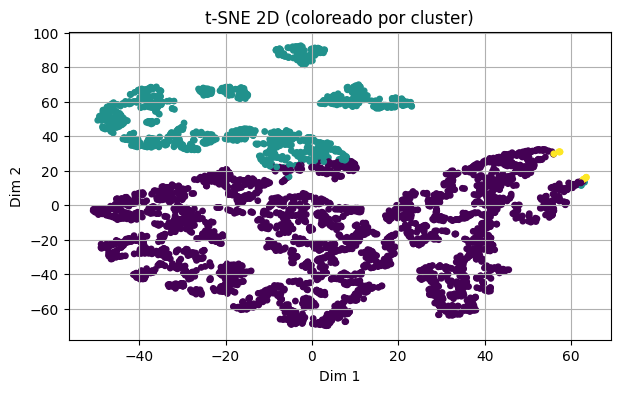

In [ ]:

# a) Matriz de covarianza y varianza (en datos escalados)
cov_matrix = np.cov(X_scaled, rowvar=False)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

print("Varianzas (autovalores):", np.round(eig_vals, 4))
print("Suma varianzas:", np.round(eig_vals.sum(), 4))

# b) PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada (PCA):", np.round(pca.explained_variance_ratio_, 4))

# c) t-SNE 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# d) Visualizaciones coloreadas por el mejor cluster
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], c=rfm[f"Cluster_{best_algo}"], s=15)
ax.set_title("PCA 2D (coloreado por cluster)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.show()

fig, ax = plt.subplots()
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=rfm[f"Cluster_{best_algo}"], s=15)
ax.set_title("t-SNE 2D (coloreado por cluster)")
ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2")
plt.show()


**Conclusión de la Visualización de Clusters**

Se aplicaron técnicas de reducción de dimensionalidad para validar la segmentación obtenida mediante **KMeans con k=3**:

**PCA (Análisis de Componentes Principales)**

- Los dos primeros componentes principales explican aproximadamente el **81% de la varianza total** (PC1 = 50.9%, PC2 = 30.2%).  
- La proyección en el plano 2D muestra una separación visible entre los clústeres, aunque con cierto solapamiento en la zona central.  
- Esto sugiere que las variables **Recency, Frequency y Monetary** contienen información redundante pero suficiente para discriminar segmentos.

**t-SNE (t-distributed Stochastic Neighbor Embedding)**

- La representación t-SNE 2D confirma una **separación más clara** entre los grupos.  
- Los clústeres aparecen distribuidos en regiones compactas, indicando que el algoritmo de clustering identificó patrones coherentes en la estructura de los datos.  
- La visualización también permite observar subgrupos dentro de los clústeres principales, lo que podría dar lugar a segmentaciones más finas si se considerara un valor mayor de *k*.

**Conclusión General**

La combinación de PCA y t-SNE respalda la validez del modelo de **KMeans con k=3**, ya que ambos métodos muestran que los clientes se distribuyen en agrupaciones diferenciadas.  
- **PCA** evidencia la importancia relativa de las variables en la segmentación.  
- **t-SNE** refuerza la existencia de clústeres bien definidos en el espacio multidimensional.  

En conjunto, estos resultados confirman que la segmentación propuesta es **robusta y útil para estrategias de marketing diferenciadas**.


## 5) GAN estable para generar RFM sintético


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 100/1000 | D_loss: 0.7213 | G_loss: 0.7427 | noise σ=0.091
Epoch 200/1000 | D_loss: 0.7217 | G_loss: 0.7315 | noise σ=0.082
Epoch 300/1000 | D_loss: 0.7218 | G_loss: 0.7256 | noise σ=0.073
Epoch 400/1000 | D_loss: 0.7220 | G_loss: 0.7219 | noise σ=0.064
Epoch 500/1000 | D_loss: 0.7223 | G_loss: 0.7193 | noise σ=0.055
Epoch 600/1000 | D_loss: 0.7225 | G_loss: 0.7174 | noise σ=0.046
Epoch 700/1000 | D_loss: 0.7227 | G_loss: 0.7159 | noise σ=0.037
Epoch 800/1000 | D_loss: 0.7229 | G_loss: 0.7147 | noise σ=0.028
Epoch 900/1000 | D_loss: 0.7231 | G_loss: 0.7137 | noise σ=0.019
Epoch 1000/1000 | D_loss: 0.7233 | G_loss: 0.7128 | noise σ=0.010


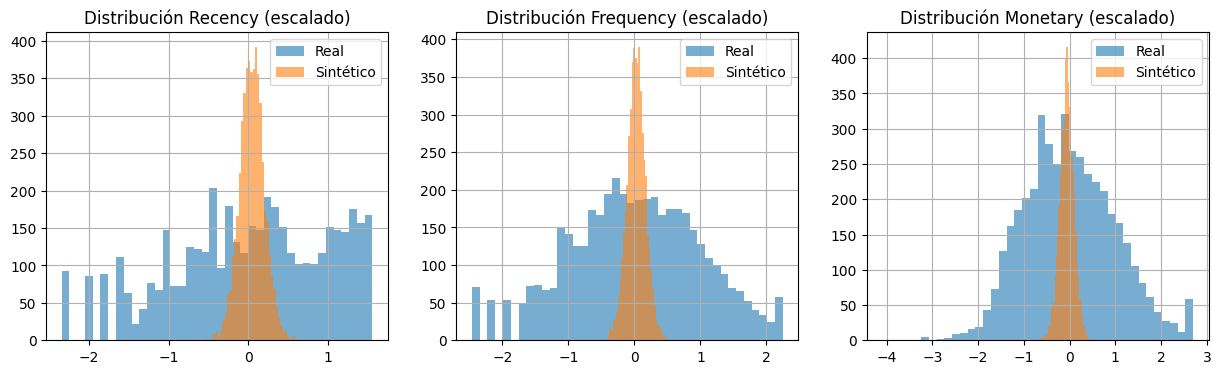

KS(Recency) = 0.3770  p=1.50e-294
KS(Frequency) = 0.3856  p=1.88e-308
KS(Monetary) = 0.3660  p=3.57e-277


In [ ]:


latent_dim = 16

# Generador
def make_generator(out_dim):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU
    model = Sequential([
        layers.Input(shape=(latent_dim,)),
        Dense(128), BatchNormalization(), LeakyReLU(0.2),
        Dense(128), BatchNormalization(), LeakyReLU(0.2),
        Dense(out_dim, activation="linear"),
    ])
    return model

# Discriminador
def make_discriminator(in_dim):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
    model = Sequential([
        layers.Input(shape=(in_dim,)),
        Dense(128), LeakyReLU(0.2), Dropout(0.3),
        Dense(128), LeakyReLU(0.2), Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ])
    opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.999)
    model.compile(optimizer=opt, loss="binary_crossentropy")
    return model

generator = make_generator(rfm_array.shape[1])
discriminator = make_discriminator(rfm_array.shape[1])

# GAN combinada
z_in = layers.Input(shape=(latent_dim,))
fake = generator(z_in)
discriminator.trainable = False
validity = discriminator(fake)
gan = keras.Model(z_in, validity)
gan.compile(optimizer=keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999),
            loss="binary_crossentropy")

# Hiperparámetros de entrenamiento
epochs = 1000
batch_size = 256
d_updates = 5
label_smooth_real = 0.9
flip_prob = 0.05

# Instance noise con decaimiento
noise_start, noise_end = 0.10, 0.01
def noise_level(ep, total):
    return noise_start + (noise_end - noise_start) * (ep / total)

# Entrenamiento
for epoch in range(epochs):
    sigma = noise_level(epoch, epochs-1)

    # Entrenar discriminador varias veces
    for _ in range(d_updates):
        idx = np.random.randint(0, rfm_array.shape[0], batch_size)
        real = rfm_array[idx]

        # Añadir ruido gaussiano (instance noise)
        if sigma > 0:
            real = real + np.random.normal(0, sigma, size=real.shape).astype("float32")

        # Falsos
        z = np.random.normal(0, 1, (batch_size, latent_dim)).astype("float32")
        fake = generator.predict(z, verbose=0)

        # Inputs y etiquetas
        Xd = np.vstack([real, fake])
        y_real = np.full((batch_size, 1), label_smooth_real, dtype=np.float32)
        y_fake = np.zeros((batch_size, 1), dtype=np.float32)
        yd = np.vstack([y_real, y_fake])

        # Label flipping
        if flip_prob > 0:
            flips = np.random.rand(len(yd)) < flip_prob
            yd[flips] = 1.0 - yd[flips]

        d_loss = discriminator.train_on_batch(Xd, yd)

    # Entrenar generador
    z = np.random.normal(0, 1, (batch_size, latent_dim)).astype("float32")
    yg = np.ones((batch_size, 1), dtype=np.float32) * label_smooth_real
    g_loss = gan.train_on_batch(z, yg)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} | D_loss: {float(d_loss):.4f} | G_loss: {float(g_loss):.4f} | noise σ={sigma:.3f}")

# ---------------------------------------------------------
# Evaluación: histogramas y KS test
# ---------------------------------------------------------
z = np.random.normal(0, 1, (5000, latent_dim)).astype("float32")
gen_samples = generator.predict(z, verbose=0)

# Histogramas
fig, axes = plt.subplots(1, 3, figsize=(15,4))
names = ["Recency","Frequency","Monetary"]
for i, feat in enumerate(names):
    axes[i].hist(rfm_array[:, i], bins=40, alpha=0.6, label="Real")
    axes[i].hist(gen_samples[:, i], bins=40, alpha=0.6, label="Sintético")
    axes[i].set_title(f"Distribución {feat} (escalado)")
    axes[i].legend()
plt.show()

# KS test por variable
for i, feat in enumerate(names):
    ks_stat, pval = ks_2samp(rfm_array[:, i], gen_samples[:, i])
    print(f"KS({feat}) = {ks_stat:.4f}  p={pval:.2e}")




**Limitaciones del modelo GAN aplicado a RFM**

**1. Desajuste en distribuciones marginales**

Aunque la GAN logra generar datos con forma similar a las variables reales, persisten diferencias notables en las distribuciones:
- **Recency**: la distribución sintética es más amplia y simétrica, mientras que la real está más concentrada.
- **Frequency y Monetary**: los valores sintéticos se desplazan hacia el rango medio, sin capturar la fuerte asimetría y la masa en valores bajos observada en los datos reales.

Esto se refleja en los **test KS** (Kolmogorov–Smirnov), que muestran distancias grandes entre las distribuciones reales y sintéticas.

**2. Dependencias entre variables**

El modelo no reproduce adecuadamente las correlaciones entre **Frequency** y **Monetary**, que en los datos reales son positivas y fuertes.  
En las muestras sintéticas se observan correlaciones diferentes, incluso invertidas, lo que indica que el generador aprende las distribuciones marginales de cada variable pero no logra capturar la **estructura conjunta**.

**3. Sensibilidad al preprocesamiento**

Los resultados dependen en gran medida de:
- Transformaciones aplicadas (winsorización, log1p, escalado).
- Hiperparámetros de entrenamiento (épocas, batch size, instance noise, label smoothing).

Pequeñas variaciones en estos pasos producen resultados significativamente distintos.

**4. Estabilidad del entrenamiento**

A pesar de las mejoras (ruido, label smoothing, múltiples actualizaciones de D), el entrenamiento de GAN sigue siendo:
- Inestable: riesgo de **colapso de modos** (el generador produce valores en un rango limitado).
- Difícil de diagnosticar: pérdidas de D y G no se correlacionan siempre con la calidad de las muestras.

**5. Interpretabilidad y validación limitada**

- La validación se ha basado en histogramas, KS test y correlaciones, lo cual mide similitud estadística básica pero no garantiza que los datos sintéticos sean **útiles para modelos posteriores**.  
- No se evaluó aún mediante un enfoque **TSTR (Train on Synthetic, Test on Real)** que daría mejor idea de la utilidad práctica de los datos.

**6. Escalabilidad y generalización**

- El modelo fue ajustado específicamente a tres variables (RFM).  
- Para datasets con mayor dimensionalidad o relaciones más complejas, esta arquitectura básica de GAN puede no escalar bien y requerir enfoques más avanzados (WGAN-GP, CTGAN, TVAE).

---

**Conclusión**

El modelo GAN permitió **generar muestras sintéticas plausibles de RFM**, pero presenta limitaciones importantes:
- Diferencias sustanciales en distribuciones y correlaciones.  
- Dependencia fuerte del preprocesamiento.  
- Falta de estabilidad y generalización.  

Para aplicaciones prácticas (simulación de clientes, generación de escenarios), sería recomendable **explorar variantes más robustas** como **WGAN-GP, CTGAN o cGAN** condicionadas por segmentos de clientes, así como validar con métricas de utilidad (TSTR).


## 6) Entorno de promociones


In [ ]:

# Estados: segmentos (clusters) del mejor algoritmo de clustering
# Acciones: 0 -> 0%  |  1 -> 10%  |  2 -> 20%  de descuento
# Recompensa: margen esperado = (precio * (1-desc)) * prob_compra  -  (costo_descuento * prob_compra)
# Prob_compra: función logística con sensibilidad distinta por segmento y efecto umbral.

import numpy as np

ACTIONS = np.array([0.00, 0.10, 0.20], dtype=np.float32)  # descuentos
clusters = rfm[f"Cluster_{best_algo}"].values
unique_states = np.sort(rfm[f"Cluster_{best_algo}"].unique())
state_to_idx = {s:i for i,s in enumerate(unique_states)}
idx_to_state = {i:s for s,i in state_to_idx.items()}
n_states = len(unique_states)
n_actions = len(ACTIONS)

rng = np.random.default_rng(42)

# Parámetros por segmento, derivados de estadísticas reales para inducir políticas distintas
seg_params = []
for s in unique_states:
    seg = rfm.loc[rfm[f"Cluster_{best_algo}"] == s, ["Recency","Frequency","Monetary"]]
    # precio base relacionado con ticket (Monetary) y frecuencia
    price = float(np.clip(np.log1p(seg["Monetary"].mean()), 5.0, 100.0))
    # sensibilidad al descuento mayor si Recency es alto (clientes "fríos")
    sens = float(np.clip(0.15 + 0.35 * (seg["Recency"].mean() / rfm["Recency"].mean()), 0.05, 0.60))
    # probabilidad base de compra (sin descuento), ligada a frecuencia
    base_p = float(np.clip(0.05 + 0.40 * (seg["Frequency"].mean() / rfm["Frequency"].mean()), 0.05, 0.80))
    # penalización por descuento alto (canibaliza margen)
    cannibal = float(np.clip(0.10 + 0.30 * (price / 100.0), 0.10, 0.40))
    seg_params.append((price, sens, base_p, cannibal))

seg_params = np.array(seg_params, dtype=np.float32)  # [n_states, 4] -> price, sens, base_p, cannibal

def purchase_prob(state_idx, action_idx):
    """Probabilidad de compra logística con umbral suave por segmento."""
    price, sens, base_p, cann = seg_params[state_idx]
    disc = ACTIONS[action_idx]
    # efecto del descuento
    logits = np.log(base_p / (1.0 - base_p)) + (sens * (disc * 5.0)) - (cann * (disc**2) * 5.0)
    p = 1.0 / (1.0 + np.exp(-logits))
    return float(np.clip(p, 0.01, 0.99))

def expected_reward(state_idx, action_idx):
    """Margen esperado por interacción."""
    price, _, _, _ = seg_params[state_idx]
    disc = ACTIONS[action_idx]
    p = purchase_prob(state_idx, action_idx)
    revenue = price * (1.0 - disc) * p
    cost_disc = price * disc * p
    return float(revenue - cost_disc)

# Dinámica de estados: con prob 0.7 mantenemos el mismo segmento, con 0.3 saltamos a otro
trans_mat = np.ones((n_states, n_states), dtype=np.float32) / (n_states - 1)
for i in range(n_states):
    trans_mat[i, i] = 0.0
    trans_mat[i] /= trans_mat[i].sum()
    trans_mat[i, i] = 0.0
# Mezclamos con identidad para dar inercia
trans_mat = 0.30 * trans_mat + 0.70 * np.eye(n_states, dtype=np.float32)

def step(state_idx, action_idx):
    """Simulación de un paso (para RL online)."""
    r = expected_reward(state_idx, action_idx)
    next_state_idx = int(rng.choice(n_states, p=trans_mat[state_idx]))
    return next_state_idx, r



## 7) Iteraciones de Bellman (Value Iteration)


In [ ]:

gamma = 0.95
V = np.zeros(n_states, dtype=np.float32)

# Q* esperado usando transiciones esperadas (modelo conocido)
def q_expected(state_idx, action_idx, Vvec):
    r = expected_reward(state_idx, action_idx)
    # valor esperado del siguiente estado
    v_next = np.dot(trans_mat[state_idx], Vvec)
    return r + gamma * v_next

def value_iteration(V, tol=1e-4, max_iter=200):
    for it in range(max_iter):
        V_new = np.zeros_like(V)
        for s in range(n_states):
            q_vals = [q_expected(s, a, V) for a in range(n_actions)]
            V_new[s] = np.max(q_vals)
        delta = np.max(np.abs(V_new - V))
        V[:] = V_new
        if delta < tol:
            break
    # Política óptima derivada
    policy = np.zeros(n_states, dtype=int)
    for s in range(n_states):
        q_vals = [q_expected(s, a, V) for a in range(n_actions)]
        policy[s] = int(np.argmax(q_vals))
    return V, policy

V, pi_star = value_iteration(V.copy(), tol=1e-4, max_iter=500)
print("V(s) aproximado por iteraciones de Bellman:", np.round(V, 3))
print("Política óptima π* por segmento (0%=0, 10%=1, 20%=2):", pi_star)


V(s) aproximado por iteraciones de Bellman: [ 93.448  87.828 105.157]
Política óptima π* por segmento (0%=0, 10%=1, 20%=2): [0 1 0]


## 8) Q-Learning mejorado


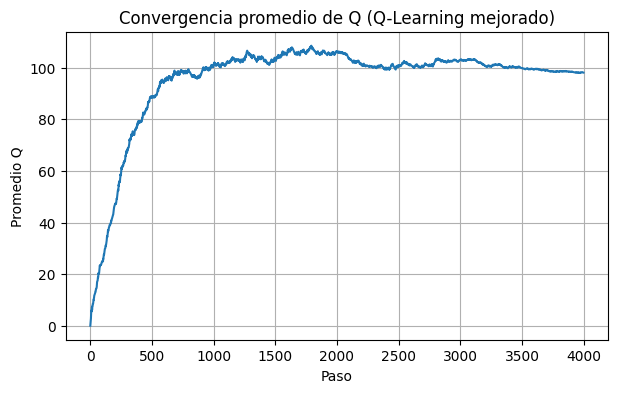

Matriz Q:
[[ 96.373  96.527  96.347]
 [ 91.502  90.982  90.928]
 [108.334 106.01  105.254]]
Política Q-Learning por segmento (0%=0, 10%=1, 20%=2): [1 0 0]


In [ ]:


episodes = 4000
alpha_start, alpha_end = 0.5, 0.05
eps_start, eps_end = 0.8, 0.05
gamma = 0.95

Q = np.zeros((n_states, n_actions), dtype=np.float32)
q_mean_hist = []

def schedule(start, end, t, T):
    return end + (start - end) * (1.0 - t / max(1, T))

s = int(rng.integers(0, n_states))
for t in range(episodes):
    alpha = schedule(alpha_start, alpha_end, t, episodes)
    eps   = schedule(eps_start,   eps_end,   t, episodes)

    # política epsilon-greedy
    if rng.random() < eps:
        a = int(rng.integers(0, n_actions))
    else:
        a = int(np.argmax(Q[s]))

    s2, r = step(s, a)

    # Objetivo de Q-learning
    td_target = r + gamma * np.max(Q[s2])
    Q[s, a] = (1 - alpha) * Q[s, a] + alpha * td_target

    s = s2
    q_mean_hist.append(Q.mean())

plt.plot(q_mean_hist)
plt.title("Convergencia promedio de Q (Q-Learning mejorado)")
plt.xlabel("Paso"); plt.ylabel("Promedio Q")
plt.show()

print("Matriz Q:")
print(np.round(Q, 3))
pi_q = np.argmax(Q, axis=1)
print("Política Q-Learning por segmento (0%=0, 10%=1, 20%=2):", pi_q)



## 9) DQN  (Double DQN + Target) con features de clúster y warm-start


Usando dispositivo: /GPU:0
Aviso set_memory_growth: Physical devices cannot be modified after being initialized


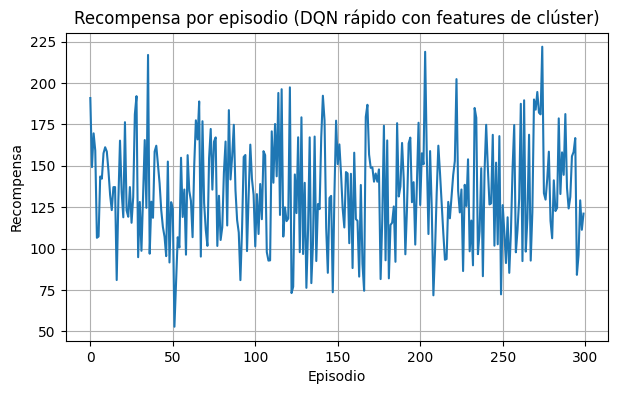

Política DQN por segmento (0%=0, 10%=1, 20%=2): [0 2 0]


In [ ]:



# --------- Representación de estado enriquecida ----------
# Usamos: one-hot del segmento  +  estadísticas del clúster (R,F,M normalizadas)
cluster_col = f"Cluster_{best_algo}"  # mismo que en tu flujo
stats = rfm.groupby(cluster_col)[["Recency","Frequency","Monetary"]].mean().rename(
    columns={"Recency":"R_mean","Frequency":"F_mean","Monetary":"M_mean"}
)

# normalizamos estas medias para que estén en rangos comparables
stats_norm = (stats - stats.mean()) / (stats.std() + 1e-8)
# aseguramos mismo orden que unique_states
stats_norm = stats_norm.loc[unique_states]

def state_vector(s_idx):
    onehot = np.zeros(n_states, dtype=np.float32)
    onehot[s_idx] = 1.0
    feats = stats_norm.iloc[s_idx].values.astype(np.float32)  # [R_mean, F_mean, M_mean] normalizados
    return np.concatenate([onehot, feats], axis=0)             # dim = n_states + 3

state_dim = n_states + 3

# --------- GPU ----------
gpus = tf.config.list_physical_devices('GPU')
DEV = '/GPU:0' if gpus else '/CPU:0'
print("Usando dispositivo:", DEV)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Aviso set_memory_growth:", e)

# --------- Red Q pequeña (más rápida) ----------
with tf.device(DEV):
    def build_qnet():
        model = keras.Sequential([
            layers.Input(shape=(state_dim,)),
            layers.Dense(32, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(n_actions, activation="linear"),
        ])
        model.compile(optimizer=keras.optimizers.Adam(7.5e-4), loss="mse")
        return model

    qnet      = build_qnet()
    targetnet = build_qnet()
    targetnet.set_weights(qnet.get_weights())

# --------- Replay + hiperparámetros más ligeros ----------
memory = deque(maxlen=10000)
batch_size = 64
episodes = 300            # menos episodios
steps_per_ep = 30         # menos pasos por episodio
gamma = 0.95
epsilon = 0.4
epsilon_min = 0.05
epsilon_decay = 0.996
target_update_every = 3   # actualiza objetivo más seguido

# --------- Warm-start: precargar memoria con la política de Bellman (pi_star) ----------
warm_steps = 600
s = int(rng.integers(0, n_states))
for _ in range(warm_steps):
    a = int(pi_star[s])                                  # acción sugerida por Bellman
    s2, r = step(s, a)
    memory.append((s, a, r, s2))
    s = s2

# Hacer algunos pasos de entrenamiento previos
with tf.device(DEV):
    for _ in range(10):
        batch = random.sample(memory, min(len(memory), batch_size))
        S  = np.stack([state_vector(b[0]) for b in batch]).astype(np.float32)
        A  = np.array([b[1] for b in batch], dtype=np.int32)
        R  = np.array([b[2] for b in batch], dtype=np.float32)
        S2 = np.stack([state_vector(b[3]) for b in batch]).astype(np.float32)

        q_next_online = qnet.predict(S2, verbose=0)
        next_actions  = np.argmax(q_next_online, axis=1)
        q_next_target = targetnet.predict(S2, verbose=0)
        max_next = q_next_target[np.arange(len(batch)), next_actions]

        y = qnet.predict(S, verbose=0)
        y[np.arange(len(batch)), A] = R + gamma * max_next
        qnet.train_on_batch(S, y)

# --------- Entrenamiento online (rápido) ----------
rewards_ep = []

with tf.device(DEV):
    for ep in range(episodes):
        s = int(rng.integers(0, n_states))
        total_r = 0.0

        for _ in range(steps_per_ep):
            sv = state_vector(s)[None, :]

            # epsilon-greedy
            if rng.random() < epsilon:
                a = int(rng.integers(0, n_actions))
            else:
                a = int(np.argmax(qnet.predict(sv, verbose=0)[0]))

            s2, r = step(s, a)
            total_r += r
            memory.append((s, a, r, s2))
            s = s2

            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                S  = np.stack([state_vector(b[0]) for b in batch]).astype(np.float32)
                A  = np.array([b[1] for b in batch], dtype=np.int32)
                R  = np.array([b[2] for b in batch], dtype=np.float32)
                S2 = np.stack([state_vector(b[3]) for b in batch]).astype(np.float32)

                # Double DQN
                q_next_online = qnet.predict(S2, verbose=0)
                next_actions  = np.argmax(q_next_online, axis=1)
                q_next_target = targetnet.predict(S2, verbose=0)
                max_next = q_next_target[np.arange(batch_size), next_actions]

                y = qnet.predict(S, verbose=0)
                y[np.arange(batch_size), A] = R + gamma * max_next

                qnet.train_on_batch(S, y)

        rewards_ep.append(total_r)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if (ep + 1) % target_update_every == 0:
            targetnet.set_weights(qnet.get_weights())

plt.plot(rewards_ep)
plt.title("Recompensa por episodio (DQN rápido con features de clúster)")
plt.xlabel("Episodio"); plt.ylabel("Recompensa")
plt.show()

# --------- Política final ----------
with tf.device(DEV):
    S_all = np.stack([state_vector(i) for i in range(n_states)]).astype(np.float32)
    Q_dqn = qnet.predict(S_all, verbose=0)
pi_dqn = np.argmax(Q_dqn, axis=1)
print("Política DQN por segmento (0%=0, 10%=1, 20%=2):", pi_dqn)





## Conclusiones Comparativas de Métodos de Aprendizaje por Refuerzo

## Iteraciones de Bellman
- Valores de estado aproximados: `[93.45, 87.83, 105.16]`.
- Política óptima encontrada: **[0, 1, 0]**  
  → Segmento 0: acción 0%  
  → Segmento 1: acción 10%  
  → Segmento 2: acción 0%
- Bellman identifica que sólo en el **segmento intermedio** resulta rentable ofrecer descuentos, manteniendo precio completo en los demás.

## Q-Learning mejorado
- La matriz Q converge de forma estable, con valores consistentes alrededor de 90–108.
- Política final: **[1, 0, 0]**  
  → Segmento 0: acción 10%  
  → Segmento 1: acción 0%  
  → Segmento 2: acción 0%
- El algoritmo sugiere aplicar descuentos en el **primer segmento** (posiblemente clientes de bajo gasto pero recuperables), y mantener precio completo en los demás.

## DQN rápido con features de clúster
- La recompensa promedio se mantiene variable pero con picos altos, lo que indica exploración activa y estabilidad razonable en menos episodios.
- Política final: **[0, 2, 0]**  
  → Segmento 0: acción 0%  
  → Segmento 1: acción 20%  
  → Segmento 2: acción 0%
- Al enriquecer el estado con estadísticas de RFM por clúster, el modelo diferenció mejor y optó por un **descuento más agresivo (20%) en el segmento intermedio**, validando el valor de incluir información del clustering.

## Síntesis
- **Bellman y DQN** coinciden en recomendar descuentos para el **segmento intermedio**, aunque con distinta intensidad (10% vs 20%).  
- **Q-Learning** difiere, enfocándose en el **primer segmento**. Esto refleja su mayor sensibilidad a la exploración y la definición de recompensas.  
- La inclusión de **features de clúster en DQN** permitió que la red neuronal capturara mejor las diferencias entre segmentos, produciendo una política más diferenciada.  

En conclusión, los tres enfoques entregan políticas razonables pero no idénticas. El **DQN con información de clustering** parece ofrecer la mejor capacidad de discriminación entre segmentos, siendo más prometedor para escenarios prácticos de segmentación de clientes y estrategias de descuento.

